In [1]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


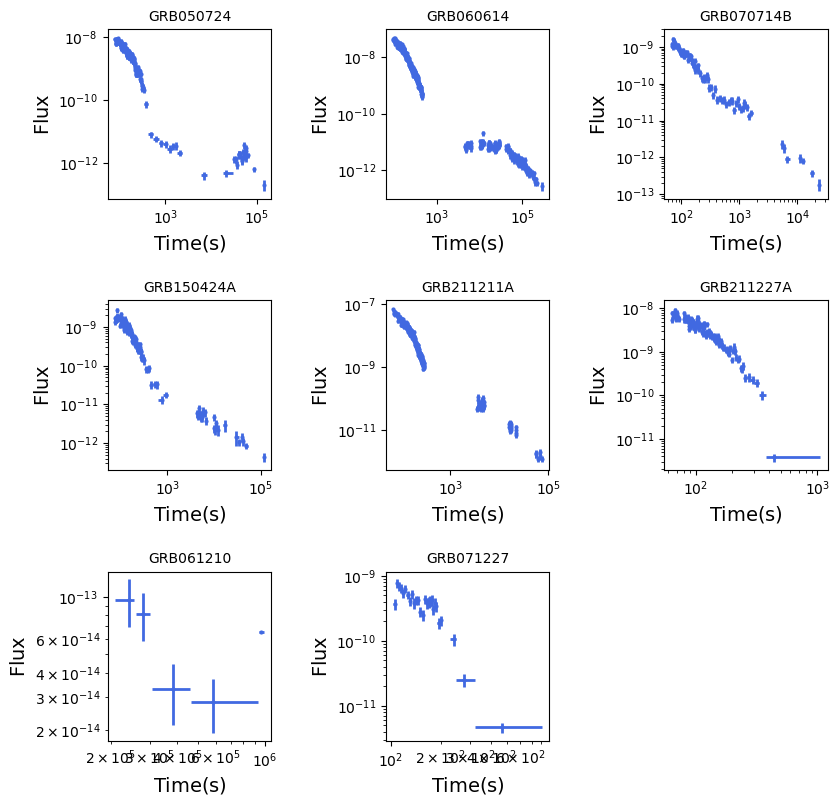

In [41]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=4

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 50
    # variables        = 2
    chi-square         = 18.5228233
    reduced chi-square = 0.38589215
    Akaike info crit   = -45.6509671
    Bayesian info crit = -41.8269211
[[Variables]]
    alpha_1:    1.29814692 +/- 0.03765266 (2.90%) (init = 1.2)
    amplitude:  3.0137e-06 +/- 1.0433e-06 (34.62%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.993


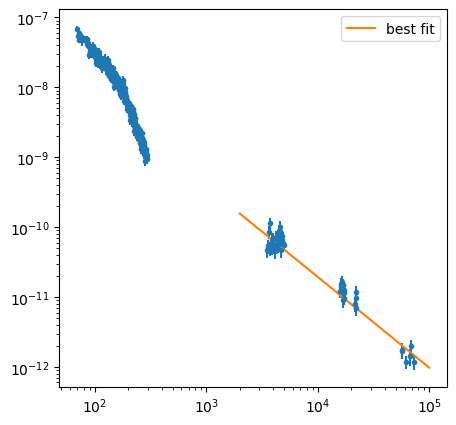

In [4]:
i=4
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 235

params=lm.Parameters()
# params.add("t_break", min = 100, max = 300, value = 173, vary=False)
# params.add("alpha_2", min = 3.0, max = 9.0, value = 6, vary=False)
params.add("alpha_1", min = 0, max = 5, value = 1.2)
params.add("amplitude", min = 1e-8, max = 1e-4, value = 1e-6)

minner = lm.Minimizer(cost_func_pl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
# tb = bfit["t_break"].value
# alp2 = bfit["alpha_2"].value
alp1 = bfit["alpha_1"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)

x1=np.linspace(2e3,1e5,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.errorbar(time[fit_index:], flux[fit_index:], fmt='o')
# plt.plot(x1,power_law(x1, 1.2, 1e-6),label ='best fit')
plt.plot(x1,power_law(x1,alp1,amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [50]:
res_refined = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)


100%|██████████| 5000/5000 [00:10<00:00, 493.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [104.79115836 108.02808823]


{'alpha_1': 1.3322467017134128, 'amplitude': 4.099403671596392e-06}

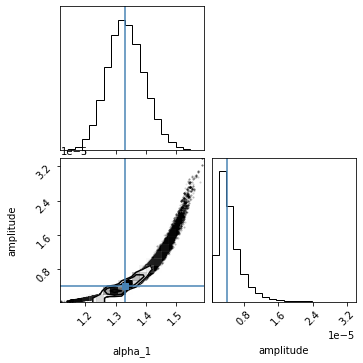

In [51]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))

res_refined.params.valuesdict()

### Initial Emission

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 59
    # data points      = 235
    # variables        = 2
    chi-square         = 576.531216
    reduced chi-square = 2.47438290
    Akaike info crit   = 214.899333
    Bayesian info crit = 221.818504
[[Variables]]
    alpha_1:    2.78914650 +/- 0.08929616 (3.20%) (init = 3)
    amplitude:  0.01143871 +/- 0.00522362 (45.67%) (init = 0.03)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.995


<Figure size 800x800 with 0 Axes>

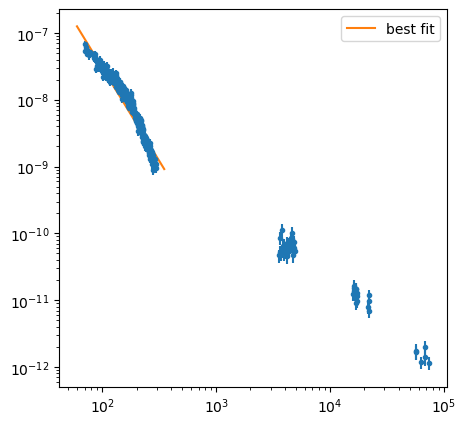

In [4]:
i=4
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 235
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 3)
params_ini.add("amplitude", min = 1e-4, max = 1, value = 3e-2)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="least_squares")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(60,350,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
# plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
# plt.plot(x1,power_law(x1, 3, 3e-2),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [77]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 5000/5000 [00:11<00:00, 421.40it/s]


{'alpha_1': 2.79602280740438, 'amplitude': 0.011841626469987182}

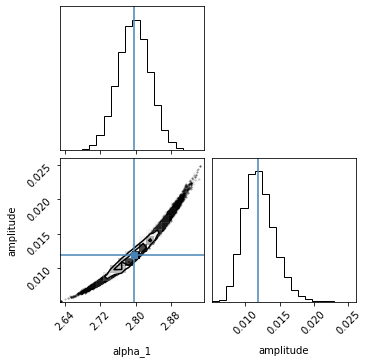

In [78]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

In [82]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 132
    # data points      = 285
    # variables        = 8
    chi-square         = 81.8966563
    reduced chi-square = 0.29565580
    Akaike info crit   = -339.403840
    Bayesian info crit = -310.183926
##  Warning: uncertainties could not be estimated:
    amplitude:  at initial value
    amplitude:  at boundary
[[Variables]]
    tb0:        177.345126 +/- 2.66365232 (1.50%) (init = 150)
    tb1:        366.469226 +/- 1.4284e+08 (38976158.65%) (init = 400)
    tb2:        1306.12333 +/-        nan (nan%) (init = 850)
    alpha_0:    2.00476562 +/- 0.04688833 (2.34%) (init = 2)
    alpha_1:    4.52087786 +/- 0.11017504 (2.44%) (init = 2.9)
    alpha_2:    0.21408581 +/- 1697576.06 (792941899.57%) (init = 0.8)
    alpha_3:    1.29814813 +/- 0.03291341 (2.54%) (init = 1.3)
    amplitude:  9.4913e-09 +/- 4.5790e-10 (4.82%) (init = 1e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb1, a

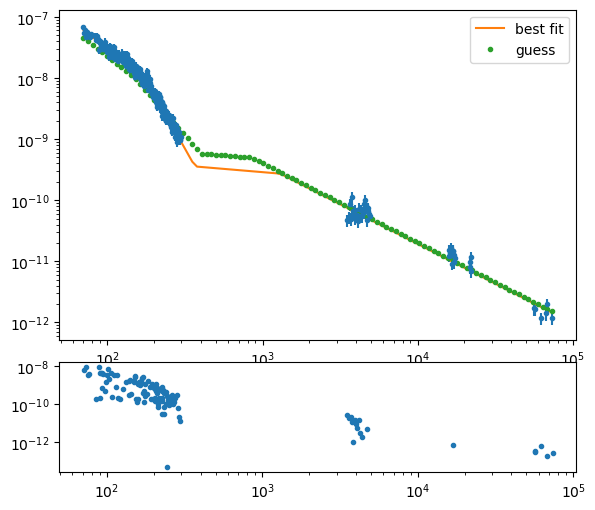

name,value,standard error,relative error,initial value,min,max,vary
tb0,177.345126,2.66365232,(1.50%),150.0,80.0000000,500.000000,True
tb1,366.469226,1.4284e+08,(38976158.65%),400.0,80.0000000,700.000000,True
tb2,1306.12333,nan,(nan%),850.0,500.000000,5000.00000,True
alpha_0,2.00476562,0.04688833,(2.34%),2.0,0.00000000,10.0000000,True
alpha_1,4.52087786,0.11017504,(2.44%),2.9,0.00000000,10.0000000,True
alpha_2,0.21408581,1697576.06,(792941899.57%),0.8,-5.00000000,10.0000000,True
alpha_3,1.29814813,0.03291341,(2.54%),1.3,0.00000000,10.0000000,True
amplitude,9.4913e-09,4.5790e-10,(4.82%),1e-08,1.0000e-09,1.0000e-07,True


In [28]:
i=4
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=4
params=lm.Parameters()
params.add("tb0", min = 8e1, max = 5e2, value = 1.5e2)
params.add("tb1", min = 8e1, max = 7e2, value = 4e2)
params.add("tb2", min = 5e2, max = 5e3, value = 8.5e2)
params.add("alpha_0", min = 0, max = 10.0, value = 2.0)
params.add("alpha_1", min = 0, max = 10, value = 2.9)
params.add("alpha_2", min = -5, max = 10.0, value = 0.8)
params.add("alpha_3", min = 0, max = 10.0, value = 1.3)
params.add("amplitude", min = 1e-9, max = 1e-7, value = 1e-8)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [1.5e2, 4e2, 8.5e2], [2.0, 2.9, 0.2, 1.3], 1e-8),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params